In [1]:
import dask_ml.joblib
from dask.distributed import Client
from sklearn.externals import joblib
from sklearn.datasets import fetch_mldata
from sklearn.linear_model import SGDClassifier
import numpy as np

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

In [2]:
mnist = fetch_mldata('MNIST original')
mnist

{'DESCR': 'mldata.org dataset: mnist-original',
 'COL_NAMES': ['label', 'data'],
 'target': array([0., 0., 0., ..., 9., 9., 9.]),
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)}

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


(-0.5, 27.5, 27.5, -0.5)

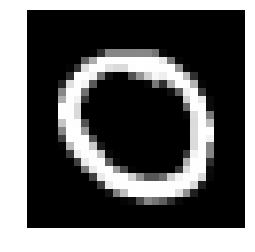

In [4]:
some_digit = X[3000]
some_digit_img = some_digit.reshape(28,28)
plt.imshow(some_digit_img, cmap="gray")
plt.axis("off")

In [5]:
# split our data into train & validation sets like good data scientists
TEST_SET_SIZE = 60_000
RANDOM_STATE = 42
X_train, X_test, y_train, y_test = X[:TEST_SET_SIZE], X[TEST_SET_SIZE:], y[:TEST_SET_SIZE], y[TEST_SET_SIZE:]

shuffle_index = np.random.RandomState(RANDOM_STATE).permutation(60_000)

X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [7]:
# let's play with Dask
if "client" in locals():
    client.close()
    
client = Client(diagnostics_port=8786)
client

/home/david/anaconda3/envs/ml/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Client Scheduler: tcp://127.0.0.1:45347 Dashboard: http://127.0.0.1:8786/status,Cluster Workers: 4 Cores: 4 Memory: 33.70 GB


In [13]:
%%time
# Binary classifer: Is it a 5?

# create labels just for 5
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

sgd_clf = SGDClassifier(
    random_state=RANDOM_STATE,
    max_iter=100,
)

# NOTE: this will only run on one core since we only have one class
# from the docs: "The number of CPUs to use to do the OVA 
# (One Versus All, for multi-class problems) computation."
with joblib.parallel_backend("dask", scatter=[X_train, y_train_5]):
    sgd_clf.fit(X_train, y_train_5)
print(sgd_clf)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', max_iter=100, n_iter=None,
       n_jobs=4, penalty='l2', power_t=0.5, random_state=42, shuffle=True,
       tol=None, verbose=0, warm_start=False)
CPU times: user 6.93 s, sys: 113 ms, total: 7.04 s
Wall time: 6.82 s


array([ True])

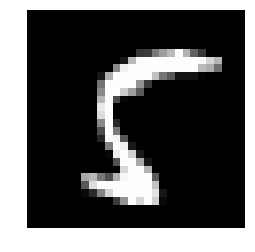

In [24]:
five_idx = np.where(y_train_5 == True)[0][1]
five_digit = X_train[five_idx]
five_digit_img = five_digit.reshape(28,28)
plt.imshow(five_digit_img, cmap="gray")
plt.axis("off")
sgd_clf.predict([five_digit])

In [15]:
# Performance Measures

from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3,random_state=RANDOM_STATE)

# "manually" doing cross-validation with stratified kfolds
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = (y_train_5[train_index])
    X_test_fold = X_train[test_index]
    y_test_fold = (y_train_5[test_index])
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9625
0.96735
0.9652


In [16]:
from sklearn.model_selection import cross_val_score

# now the easy way
# note this uses stratifiedKFolds under the hood http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html
with joblib.parallel_backend("dask", scatter=[X_train, y_train_5]):
    cross_val_score(
        sgd_clf,
        X_train,
        y_train_5,
        cv=3,
        scoring="accuracy",
    )

In [17]:
# Making an intentionally bad etimator to show that numbers lie

from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()
with joblib.parallel_backend("dask", scatter=[X_train, y_train_5]):
    cross_val_score(
        never_5_clf,
        X_train,
        y_train_5,
        cv=3,
        scoring="accuracy",
    )
# we get 90%+ scores because only 10% of our data could possibly be 5s
# ergo accuracy is not a great measure for models

In [18]:
# Confusion Matrix

from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf,X_train,y_train_5,cv=3)
print(y_train_pred.shape)

"""
                         Predicted
                    Negative    Positive
        Negative  [[True neg,   False neg],
Actual
        Positive   [False pos,  True pos]]
"""
confusion_matrix(y_train_5, y_train_pred)


(60000,)


array([[53611,   968],
       [ 1131,  4290]])

In [21]:
# Precision and Recall

# Precision
# TP / (TP + FP)
# How many times were we right when we said something was a 5?

# Recall
# TP / (TP + FN)
# Of the 5s that existed, how many did we correctly guess?

# F1 Score
# A score comprised of both precision & accuracy. Is only high when both are high

# Note that depending on our use case, we may prefer to have 
# higher precision (detecting shoplifting) or higher recall (NSFW classifier)

from sklearn.metrics import precision_score, recall_score, f1_score
print(f"Precision: {precision_score(y_train_5, y_train_pred)}")
print(f"Recall: {recall_score(y_train_5, y_train_pred)}")
print(f"F1: {f1_score(y_train_5, y_train_pred)}")


Precision: 0.8158995815899581
Recall: 0.7913669064748201
F1: 0.8034460155445267


In [25]:
# Precision/Recall Tradeoff

# sklearn also gives us the ability to just return the raw output of 
# decision functions, where we can set our own threshold for classification
some_score = sgd_clf.decision_function([five_digit])
print(some_score)
threshold1 = 0
threshold2 = 20_000
print(some_score > threshold1)
print(some_score > threshold2)

[10952.4068498]
[ True]
[False]


(59964,)
-155750.06940303944
51796.73578234703


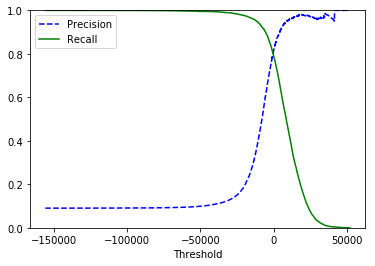

In [29]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(
    sgd_clf,
    X_train,
    y_train_5,
    cv=3,
    method="decision_function"
)
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0,1])
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


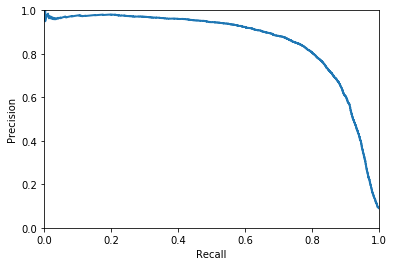

In [33]:
# we can also just plot precision against recall
def plot_precision_recall(precisions, recalls):
    plt.plot(recalls, precisions, linewidth=2, label="Precision")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.axis([0,1,0,1])

plot_precision_recall(precisions, recalls)

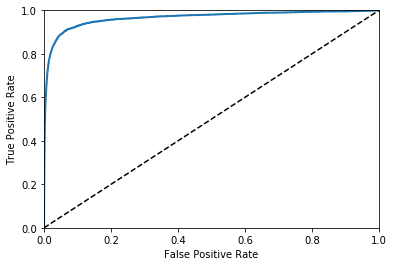

In [30]:
# The ROC Curve
# ROC stands for "receiver operating characteristic"
# which is true positive rate vs false positive rate

from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1],[0,1], "k--")
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)

In [31]:
from sklearn.metrics import roc_auc_score

# NOTE: rule of thumb - use PR curve when positive class is rare
# or we care more about false positives than false negatives
# use ROC otherwise

# AUC Score or "Area Under the Curve" score of 1 is a perfect model,
# and an auc of .5 is purely random
roc_auc_score(y_train_5, y_scores)


0.9658120874858911

In [34]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=RANDOM_STATE)
with joblib.parallel_backend("dask", scatter=[X_train, y_train_5]):
    y_probas_forest = cross_val_predict(
        forest_clf,
        X_train,
        y_train_5,
        cv=3,
        method="predict_proba"
    )

Random Forest AUC: 0.9931243366003829


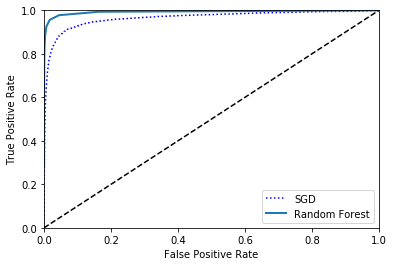

In [36]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")

print(f"Random Forest AUC: {roc_auc_score(y_train_5,y_scores_forest)}")

In [39]:
# Multi-class Classification

# sklearn detects when you're doing single vs multiclass. Easy!
# also now dask works as expected because we're doing one-versus-all (OVA)
# instead of one-versus-one (OVO) (for single class and SVMs)
with joblib.parallel_backend("dask", scatter=[X_train, y_train]):
    some_digit_scores = sgd_clf.fit(X_train, y_train) # now doing multiclass

In [41]:
print(sgd_clf.predict([five_digit]))
# notice here the highest score is our chosen class
print(sgd_clf.decision_function([five_digit]))
print(sgd_clf.classes_)

[5.]
[[  1692.92018492 -34849.77412644 -19244.39206792 -44305.75638357
  -35920.8104718   10952.4068498  -32024.7879121  -23801.6180984
   -9506.03287898 -21542.61516144]]
[0. 1. 2. 3. 4. 5. 6. 7. 8. 9.]


In [43]:
from sklearn.multiclass import OneVsOneClassifier

# here we can force the use of OVO rather than OVA
ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=RANDOM_STATE, max_iter=50))
ovo_clf.fit(X_train, y_train)
print(len(ovo_clf.estimators_)) # one binary classifer for each digit versus each other digit
ovo_clf.predict([five_digit])

45


array([5.])

In [45]:
forest_clf.fit(X_train, y_train)
print(forest_clf.predict([five_digit]))
print(forest_clf.predict_proba([five_digit]))


[5.]
[[0.  0.  0.  0.  0.  0.9 0.1 0.  0.  0. ]]


In [47]:
# Now that we've trained our multi-class classifiers, let's see how good they are
from sklearn.preprocessing import StandardScaler

with joblib.parallel_backend("dask", scatter=[X_train, y_train]):
    print(cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy"))
    # this is okay, but we can do better just by scaling inputs
    # note that 10% accuracy would be a random guess

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
    print(cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy"))


[0.87267546 0.85169258 0.81547232]
[0.91321736 0.91309565 0.90953643]
